## INIT
Just noting which env im using here (will remove later):

/opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install

In [2]:
import xarray as xr
import xeofs as xe
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.crs import CRS
import numpy as np

# For masking:
from shapely.geometry import mapping, shape
from shapely.ops import transform
import pyproj

In [4]:
sst_file = xr.open_dataset('sst.mnmean.nc').sst

## Functions

In [6]:
## Helper to fix coords in sst data
# lons load as 0:360, need them -180:180

# ran into issues when trying to edit original sst dataset, this method seems to avoid those probs
def fix_lons(da):
    new_lon = da.lon.where(da.lon <= 180, da.lon - 360)
    new_da = xr.DataArray(data = da.values, coords = [da.time,da.lat, new_lon], attrs = da.attrs)
    return new_da.sortby('lon')

In [7]:
## Masking out land from interpolated data

#Preprocessing for the shapefile, not interesting or critical
# 1. Load Shapefile
gdf = gpd.read_file('Continents_Shapefile.geojson')
gdf.drop(index = 5, inplace = True)

# Standardize continent names for grouping
gdf['CONTINENT'] = gdf['CONTINENT'].replace(
    {'Australia': 'Oceania'})

# Dissolve geometries by continent name
cont_mask = gdf.dissolve(
    by='CONTINENT', 
    aggfunc={'SQMI': 'sum', 'SQKM': 'sum'}  # Sum area statistics
).reset_index()

def mask_land(da, mask):
    da = da.rio.write_crs(CRS.from_epsg(4326))
    clipped = da.rio.clip(mask.geometry, mask.crs, invert = True)
    return clipped

In [8]:
# Filler basic pca function
def linear_pca(data, n_pcs = 8):
    pca = xe.single.EOF(n_modes = n_pcs)
    pcs = pca.fit_transform(data, dim = 'time')
    return pca, pcs

# Plot important stats for a given pc
def plot_pc_info(pca, pcs, mode = 1):
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10,8), layout = 'constrained')
    fig.suptitle(f"PC{mode} of SST data and components, exp. var: {pca.explained_variance_ratio()[mode].values:.4f}")
    pcs.sel(mode = mode).plot(ax = ax[0])
    ax[0].set_title("")
    ax[1].set_title("")
    pca.components().sel(mode = mode).plot(ax = ax[1])

## End of Functions, Start working code

In [9]:
sst = fix_lons(sst_file)
masked_sst = mask_land(sst, cont_mask)

In [10]:
anoms = masked_sst.groupby('time.month') - masked_sst.groupby('time.month').mean('time')

In [12]:
pca, sst_pcs = linear_pca(anoms, n_pcs = 20)

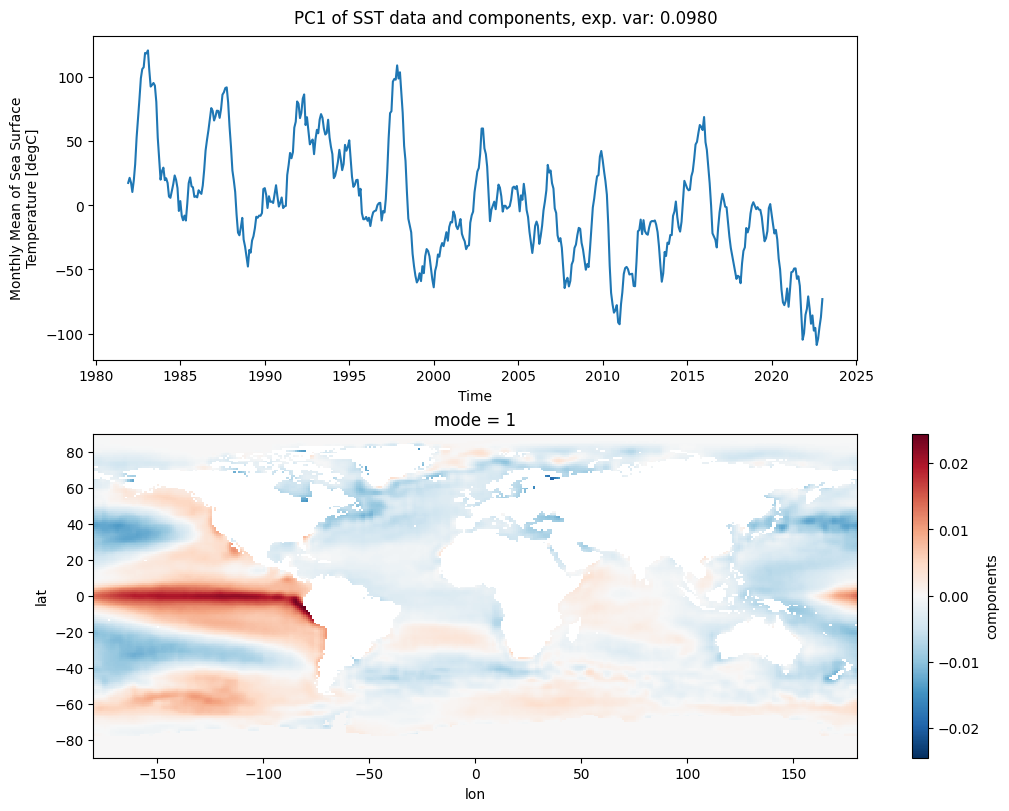

In [15]:
plot_pc_info(pca, sst_pcs, mode = 1)